In [ ]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(cowplot)
library(ggplot2)
library(broom)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [ ]:
data <- read.csv("listings.csv", header = TRUE) %>%
    select(-id, -name, -host_id, -host_name, -host_since, -neighbourhood_cleansed, -property_type, -license)
data <- na.omit(data)
#data["beds_per_accomodate"] = round(data$accommodates / data$beds, 2)
# data <- data %>%
#    filter(beds != 0)
# data <- data %>%
#     select(-beds, -accommodates)
data <- data %>%
    filter(host_response_time != 'N/A')
    
superhost_count <- data %>% count(host_is_superhost) %>% arrange(desc(n))
data <- data %>% 
    filter(host_is_superhost != superhost_count$host_is_superhost[3])


data <- data %>%
    mutate(host_response_time = as.factor(host_response_time) ,
           host_response_rate = as.numeric(host_response_rate), 
           host_is_superhost = as.factor(host_is_superhost), 
           neighbourhood_group_cleansed = as.factor(neighbourhood_group_cleansed), 
           room_type = as.factor(room_type),
           instant_bookable = as.factor(instant_bookable))

data["log_price"] = log(data$price)

head(data)

,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable
,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<fct>
1,a few days or more,0.2,f,Other Cities,34.10933,-118.0731,Private room,2,1.0,1,1,49,1,364,1,3.00,f
2,within an hour,1.0,t,Other Cities,34.01559,-118.4941,Entire home/apt,2,1.0,0,1,231,5,193,44,4.93,t
3,within a few hours,1.0,f,City of Los Angeles,33.99017,-118.4225,Entire home/apt,7,1.0,2,5,110,30,117,368,4.61,f
4,within an hour,1.0,t,City of Los Angeles,33.98258,-118.4643,Entire home/apt,6,3.5,4,4,1179,2,356,35,4.97,f
5,within an hour,1.0,t,City of Los Angeles,34.08817,-118.3655,Entire home/apt,8,4.5,4,4,1244,3,141,10,5.00,f
6,within an hour,1.0,t,Other Cities,34.09130,-118.3519,Entire home/apt,5,1.0,2,3,213,2,244,23,4.74,t


In [3]:
dim(data)

[1] 24947    17

In [4]:
colSums(is.na(data))

host_response_time           host_response_rate 
                           0                            0 
           host_is_superhost neighbourhood_group_cleansed 
                           0                            0 
                    latitude                    longitude 
                           0                            0 
                   room_type                 accommodates 
                           0                            0 
                   bathrooms                     bedrooms 
                           0                            0 
                        beds                        price 
                           0                            0 
              minimum_nights             availability_365 
                           0                            0 
           number_of_reviews         review_scores_rating 
                           0                            0 
            instant_bookable 
                           0

In [5]:

data %>% count(host_response_time) %>% mutate(prop = n / nrow(data))

host_response_time,n,prop
<fct>,<int>,<dbl>
a few days or more,450,0.01803824
within a day,1164,0.04665892
within a few hours,3234,0.12963483
within an hour,20099,0.80566802


In [6]:
str(data)

'data.frame':	24947 obs. of  17 variables:
 $ host_response_time          : Factor w/ 4 levels "a few days or more",..: 1 4 3 4 4 4 4 3 4 4 ...
 $ host_response_rate          : num  0.2 1 1 1 1 1 1 1 1 1 ...
 $ host_is_superhost           : Factor w/ 2 levels "f","t": 1 2 1 2 2 2 2 1 1 1 ...
 $ neighbourhood_group_cleansed: Factor w/ 3 levels "City of Los Angeles",..: 2 2 1 1 1 2 1 1 2 2 ...
 $ latitude                    : num  34.1 34 34 34 34.1 ...
 $ longitude                   : num  -118 -118 -118 -118 -118 ...
 $ room_type                   : Factor w/ 4 levels "Entire home/apt",..: 3 1 1 1 1 1 1 1 1 1 ...
 $ accommodates                : int  2 2 7 6 8 5 4 3 2 2 ...
 $ bathrooms                   : num  1 1 1 3.5 4.5 1 1 1 1 1 ...
 $ bedrooms                    : int  1 0 2 4 4 2 2 1 1 1 ...
 $ beds                        : int  1 1 5 4 4 3 3 1 1 1 ...
 $ price                       : int  49 231 110 1179 1244 213 95 298 110 153 ...
 $ minimum_nights              : int  1 5 30 

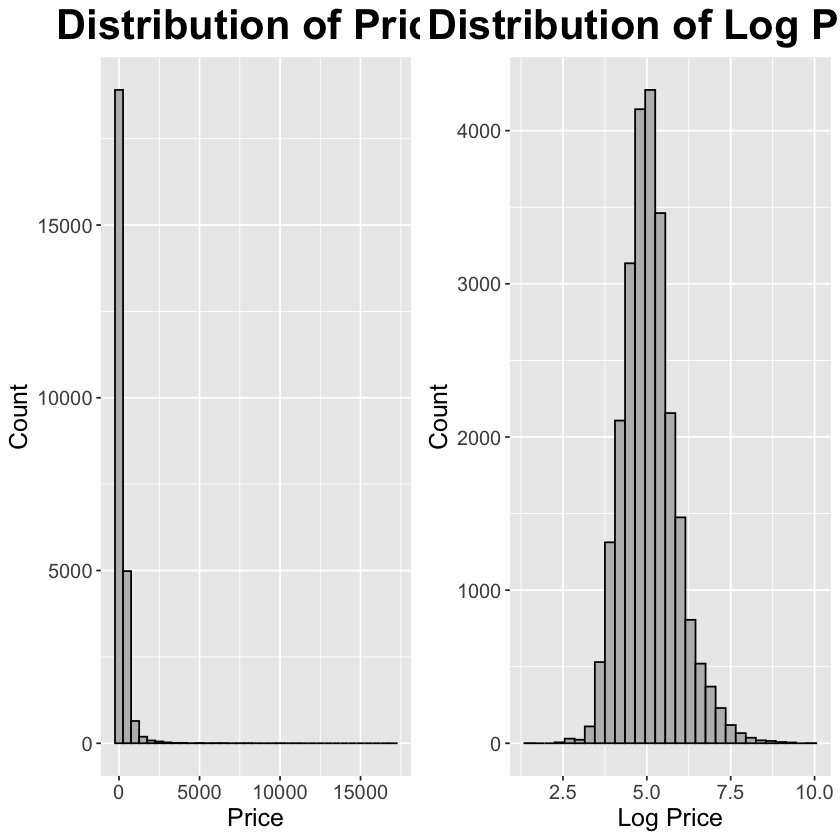

In [71]:
price_dist <- data %>%
    ggplot(aes(price)) + 
    geom_histogram(binwidth = 500, color = "black", fill ="#bcbbbb") +
    labs(title = "Distribution of Price",
        x = "Price", y = "Count") +
    theme(
    plot.title = element_text(size = 25, face = "bold", hjust = 0.5),    # Title size
    axis.title = element_text(size = 15),                  # Axis titles size
    axis.text = element_text(size = 12)                    # Axis labels size
  )

price_dist2 <- data %>%
    ggplot(aes(log_price)) + 
    geom_histogram(binwidth = 0.3, color = "black", fill ="#bcbbbb") +
    labs(title = "Distribution of Log Price",
        x = "Log Price", y = "Count") +
    theme(
    plot.title = element_text(size = 25, face = "bold", hjust = 0.5),    # Title size
    axis.title = element_text(size = 15),                  # Axis titles size
    axis.text = element_text(size = 12)                    # Axis labels size
  )
price_dist_combined <- grid.arrange(price_dist, price_dist2, ncol = 2)
ggsave("price_dist.png", plot = price_dist_combined, width = 15, height = 7, units = "in", dpi = 300)

The distribution of the price column is right-skewed, thus we will try to apply a log transformation to the price column.

Warning message:
“Removed 168 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


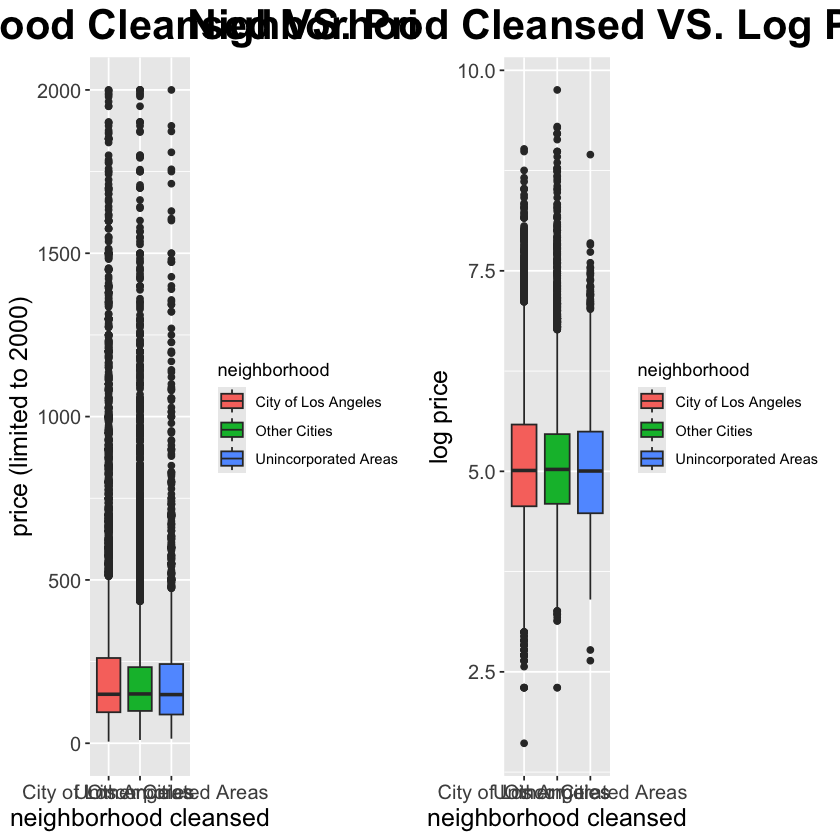

In [80]:
neighborhood_boxplot <- data %>%
    ggplot(aes(x=neighbourhood_group_cleansed,y = price, fill=neighbourhood_group_cleansed)) +
    geom_boxplot() +
    ylim(c(0, 2000)) +
    xlab("neighborhood cleansed") +
    ylab("price (limited to 2000)") +
    labs(fill = "neighborhood", title = "Nighborhood Cleansed VS. Price") +
    theme(
        plot.title = element_text(size = 25, face = "bold", hjust = 0.5),    # Title size
        axis.title = element_text(size = 15),                                # Axis titles size
        axis.text = element_text(size = 12))


neighborhood_boxplot2 <- data %>%
    ggplot(aes(x=neighbourhood_group_cleansed,y = log_price, fill=neighbourhood_group_cleansed)) +
    geom_boxplot() +
    xlab("neighborhood cleansed") +
    ylab("log price") +
    labs(fill = "neighborhood", title = "Nighborhood Cleansed VS. Log Price") +
    theme(
        plot.title = element_text(size = 25, face = "bold", hjust = 0.5),    # Title size
        axis.title = element_text(size = 15),                                # Axis titles size
        axis.text = element_text(size = 12))

ne_combined <- grid.arrange(neighborhood_boxplot, neighborhood_boxplot2, ncol = 2)
ggsave("neighborhood_boxplot.png", plot = ne_combined, width = 20, height = 10, units = "in", dpi = 600)

In [12]:
colnames(data)

[1] "host_response_time"           "host_response_rate"          
 [3] "host_is_superhost"            "neighbourhood_group_cleansed"
 [5] "latitude"                     "longitude"                   
 [7] "room_type"                    "accommodates"                
 [9] "bathrooms"                    "bedrooms"                    
[11] "beds"                         "price"                       
[13] "minimum_nights"               "availability_365"            
[15] "number_of_reviews"            "review_scores_rating"        
[17] "instant_bookable"

In [13]:
data <- data %>% select(-longitude, -latitude)


In [81]:
host_response_boxplot <- data %>%
    ggplot(aes(x=host_response_time,y = price, fill=host_response_time)) +
    geom_boxplot() +
    ylim(c(0, 1000)) +
    xlab("host response time") +
    ylab("price") +
    labs(fill = "neighborhood") +
    ggtitle("Price Vs. Host Response Time") +
    theme(
        plot.title = element_text(size = 25, face = "bold", hjust = 0.5),    # Title size
        axis.title = element_text(size = 15),                                # Axis titles size
        axis.text = element_text(size = 12))

host_response_boxplot2 <- data %>%
    ggplot(aes(x=host_response_time,y = log_price, fill=host_response_time)) +
    geom_boxplot() +
    xlab("host response time") +
    ylab("log price") +
    labs(fill = "neighborhood") +
    ggtitle("Log Price Vs. Host Response Time") +
    theme(
        plot.title = element_text(size = 25, face = "bold", hjust = 0.5),    # Title size
        axis.title = element_text(size = 15),                                # Axis titles size
        axis.text = element_text(size = 12))

Warning message:
“Removed 622 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


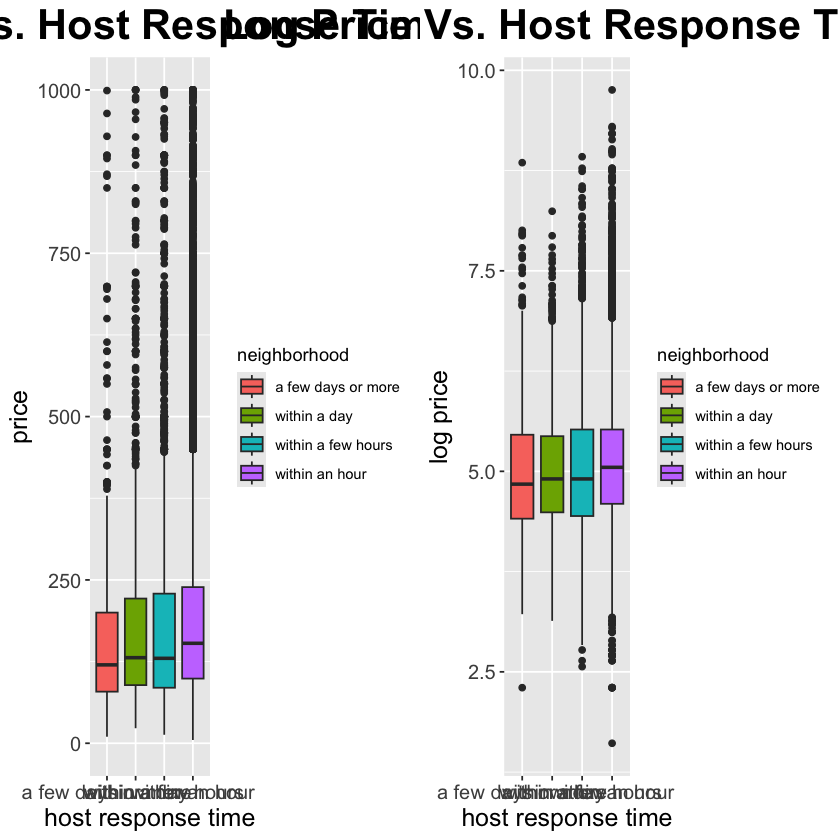

In [82]:

combined_plot <- grid.arrange(
  host_response_boxplot, 
  host_response_boxplot2, 
  ncol = 2
)
ggsave("response_time.png", plot = combined_plot, width = 20, height = 10, unit = "in", dpi = 600)

$title
[1] "Host Rponse Time Boxplot"

attr(,"class")
[1] "labels"

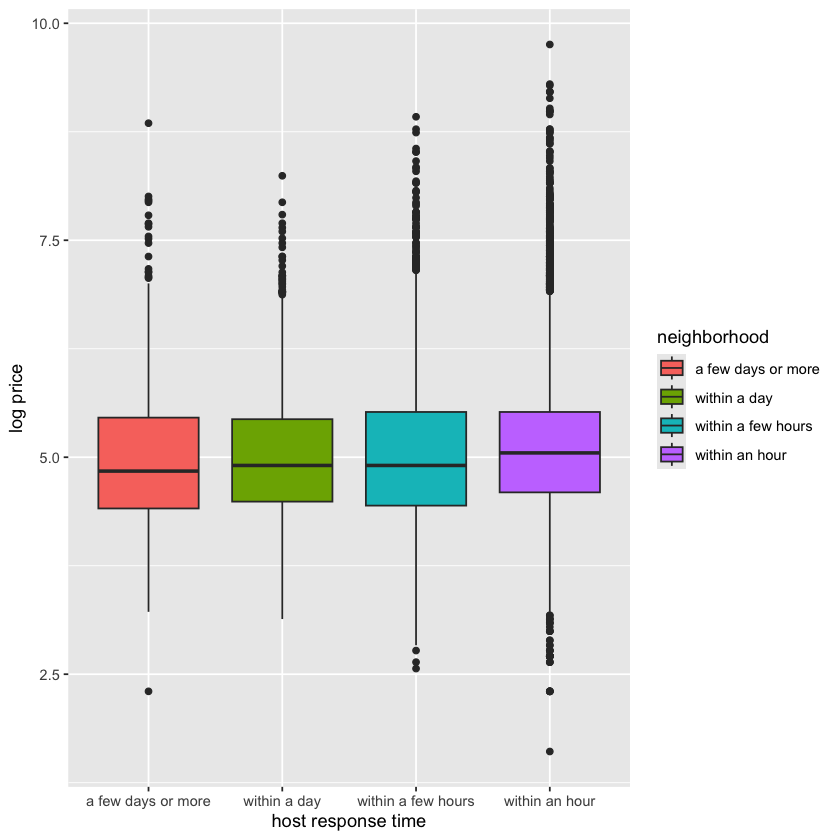

In [38]:
host_response_boxplot2 <- data %>%
    ggplot(aes(x=host_response_time,y = log_price, fill=host_response_time)) +
    geom_boxplot() +
    xlab("host response time") +
    ylab("log price") +
    labs(fill = "neighborhood")
    ggtitle("Host Rponse Time Boxplot")
host_response_boxplot2

$title
[1] "host is superhost Boxplot"

attr(,"class")
[1] "labels"

Warning message:
“Removed 622 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


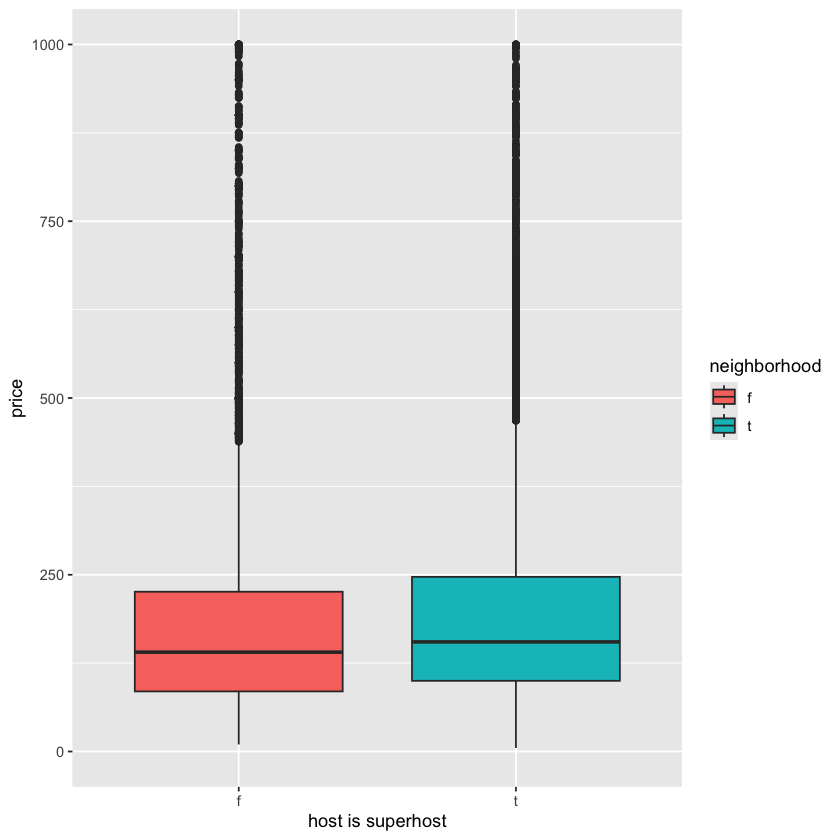

In [19]:
host_is_superhost_boxplot <- data %>%
    ggplot(aes(x=host_is_superhost,y = price, fill=host_is_superhost)) +
    geom_boxplot() +
    ylim(c(0, 1000)) +
    xlab("host is superhost") +
    ylab("price") +
    labs(fill = "neighborhood")
    ggtitle("host is superhost Boxplot")
host_is_superhost_boxplot

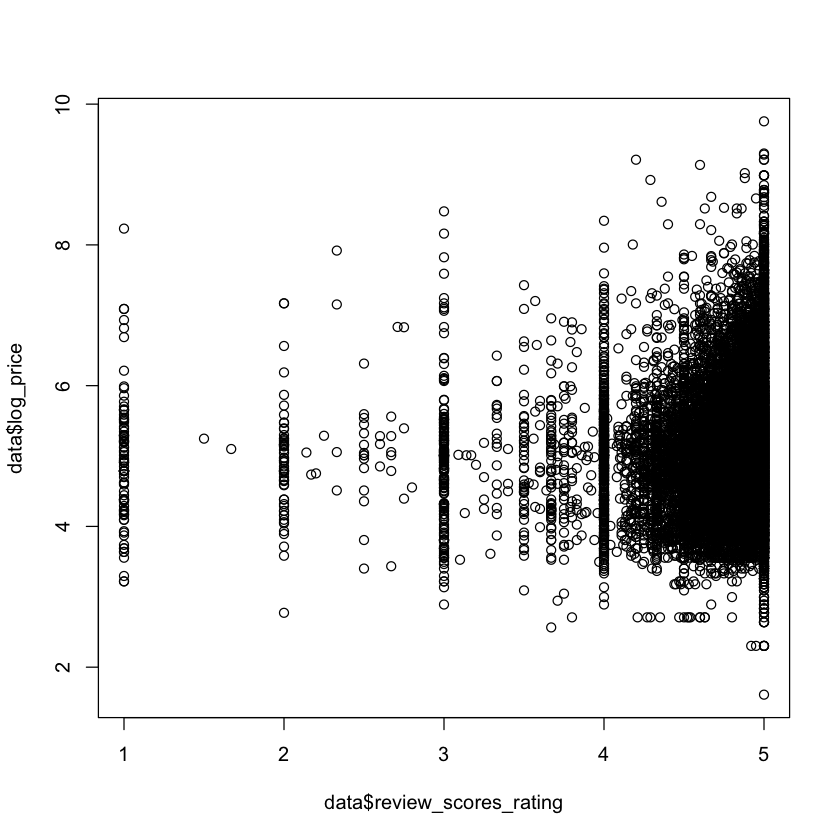

In [83]:
plot(data$review_scores_rating, data$log_price)

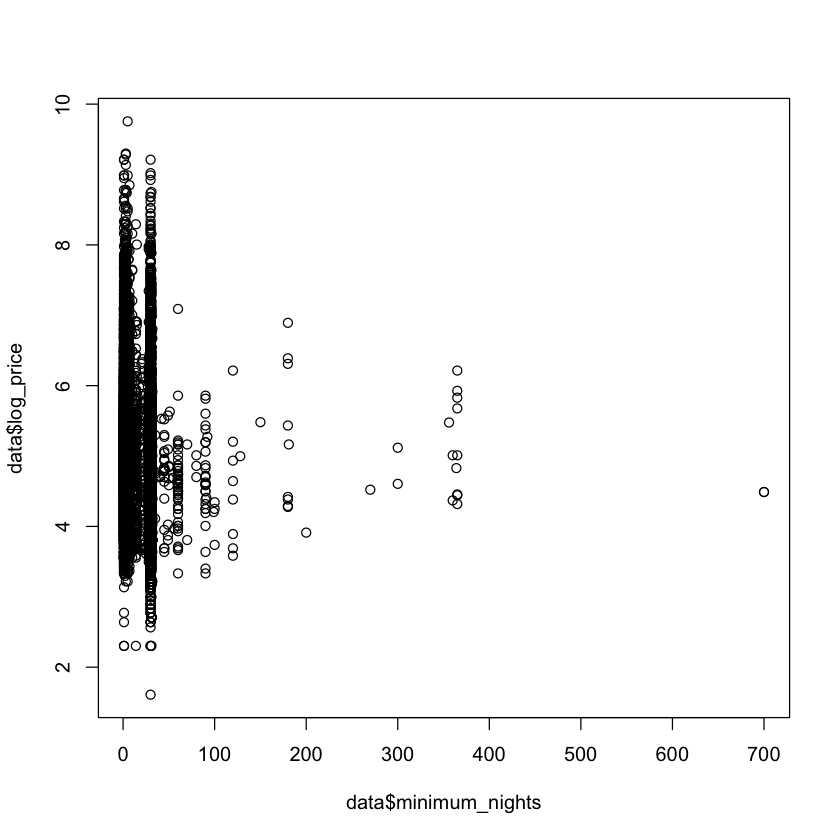

In [85]:
plot(data$minimum_nights, data$log_price)

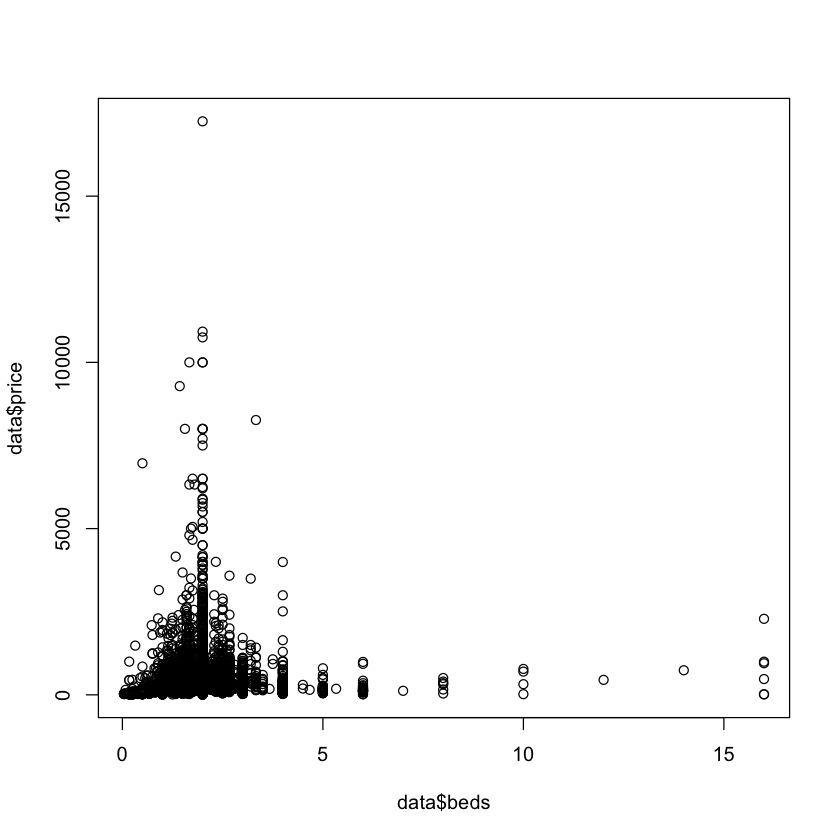

In [ ]:
plot(data$beds, data$price)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


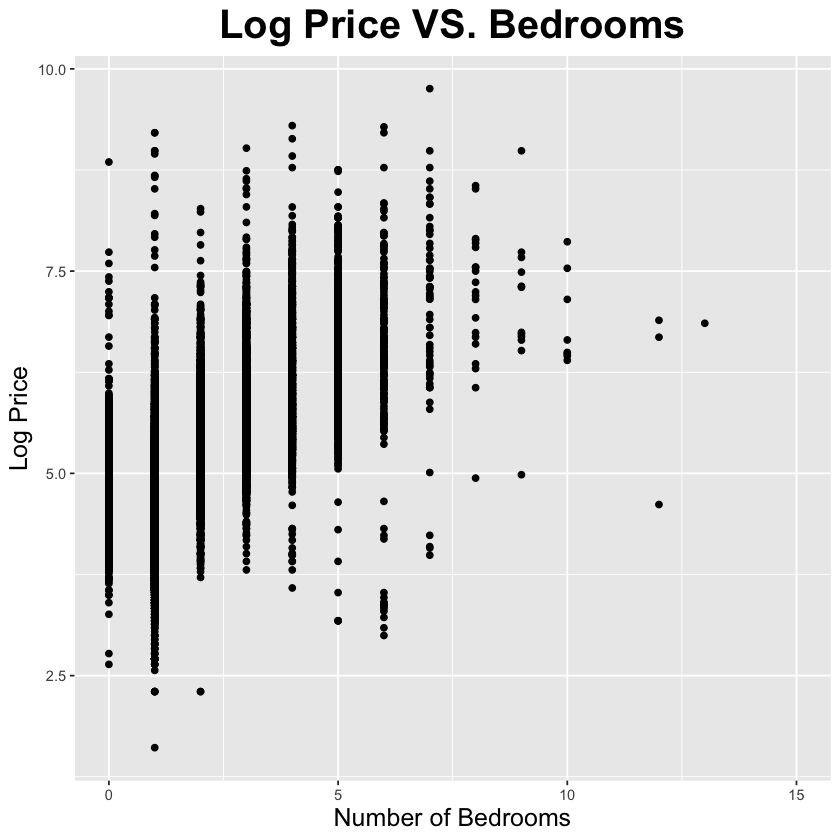

In [119]:
bathrooms_log_price <- data %>% 
    ggplot(aes(bathrooms, log_price)) +
    geom_point() +
    xlim(c(0, 15)) +
    labs(x = "Number of Bathrooms", y = "Log Price",
    title = "Log Price VS. Bathrooms") +
    theme(plot.title = element_text(size = 24,face = "bold", hjust = 0.5),
    axis.title = element_text(size = 15))

beds_log_price <-  data %>% 
    ggplot(aes(beds, log_price)) +
    geom_point() +
    xlim(c(0, 30)) +
    labs(x = "Number of Beds", y = "Log Price",
    title = "Log Price VS. Beds") +
    theme(plot.title = element_text(size = 24,face = "bold", hjust = 0.5),
    axis.title = element_text(size = 15))

bedrooms_log_price <-  data %>% 
    ggplot(aes(bedrooms, log_price)) +
    geom_point() +
    xlim(c(0, 15)) +
    labs(x = "Number of Bedrooms", y = "Log Price",
    title = "Log Price VS. Bedrooms") +
    theme(plot.title = element_text(size = 24,face = "bold", hjust = 0.5),
    axis.title = element_text(size = 15))

acco_log_price <-  data %>% 
    ggplot(aes(accommodates, log_price)) +
    geom_point() +
    #xlim(c(0, 15)) +
    labs(x = "Number of Accommodates", y = "Log Price",
    title = "Log Price VS. Accommodates") +
    theme(plot.title = element_text(size = 20,face = "bold", hjust = 0.5),
    axis.title = element_text(size = 15))

bedrooms_log_price

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


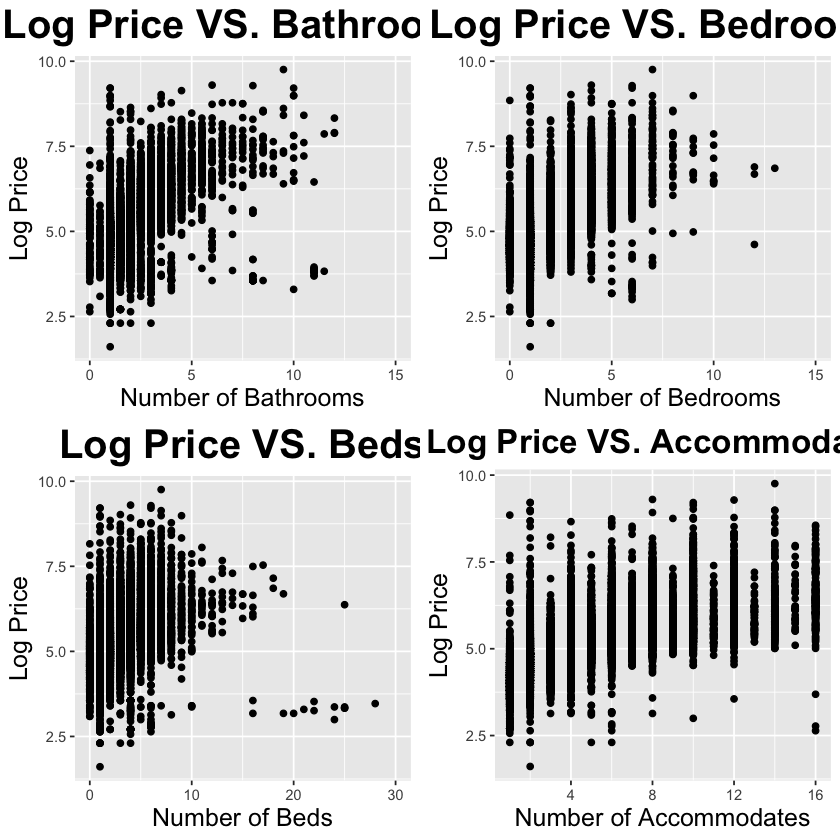

In [120]:
scatter_combined <- grid.arrange(bathrooms_log_price, bedrooms_log_price, beds_log_price, acco_log_price, ncol = 2, nrow = 2)
ggsave("plots/scatter.png", plot = scatter_combined, width = 10, height = 10, units = "in", dpi = 600)

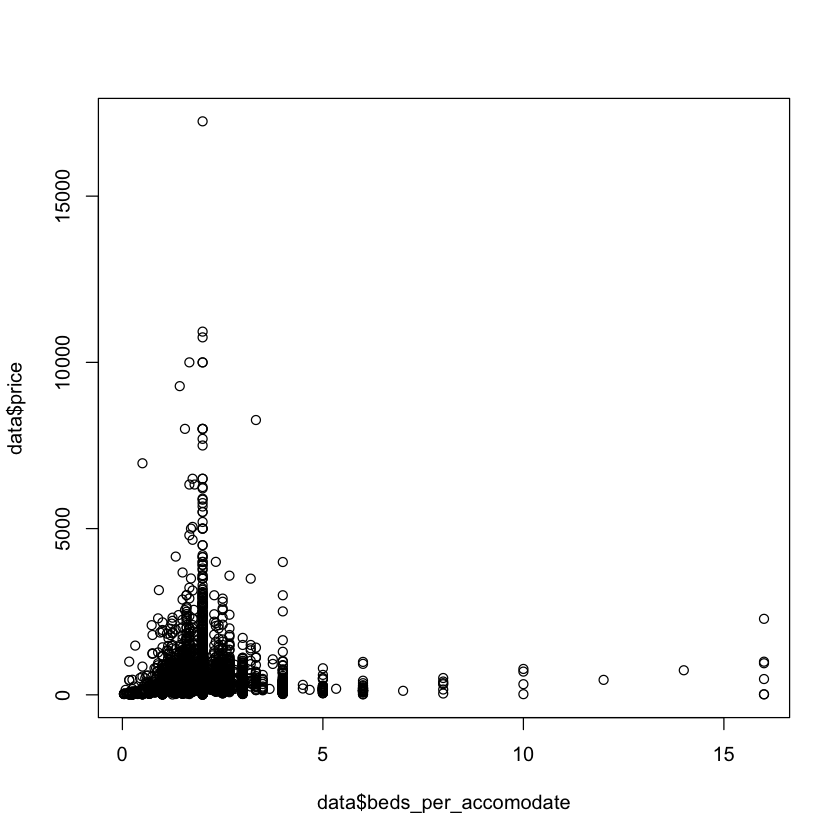

In [ ]:
plot(data$beds_per_accomodate, data$price)

In [ ]:
colnames(data)

[1] "id"                           "name"                        
 [3] "host_id"                      "host_name"                   
 [5] "host_since"                   "host_response_time"          
 [7] "host_response_rate"           "host_is_superhost"           
 [9] "neighbourhood_cleansed"       "neighbourhood_group_cleansed"
[11] "latitude"                     "longitude"                   
[13] "property_type"                "room_type"                   
[15] "accommodates"                 "bathrooms"                   
[17] "bedrooms"                     "beds"                        
[19] "price"                        "minimum_nights"              
[21] "availability_365"             "number_of_reviews"           
[23] "review_scores_rating"         "license"                     
[25] "instant_bookable"

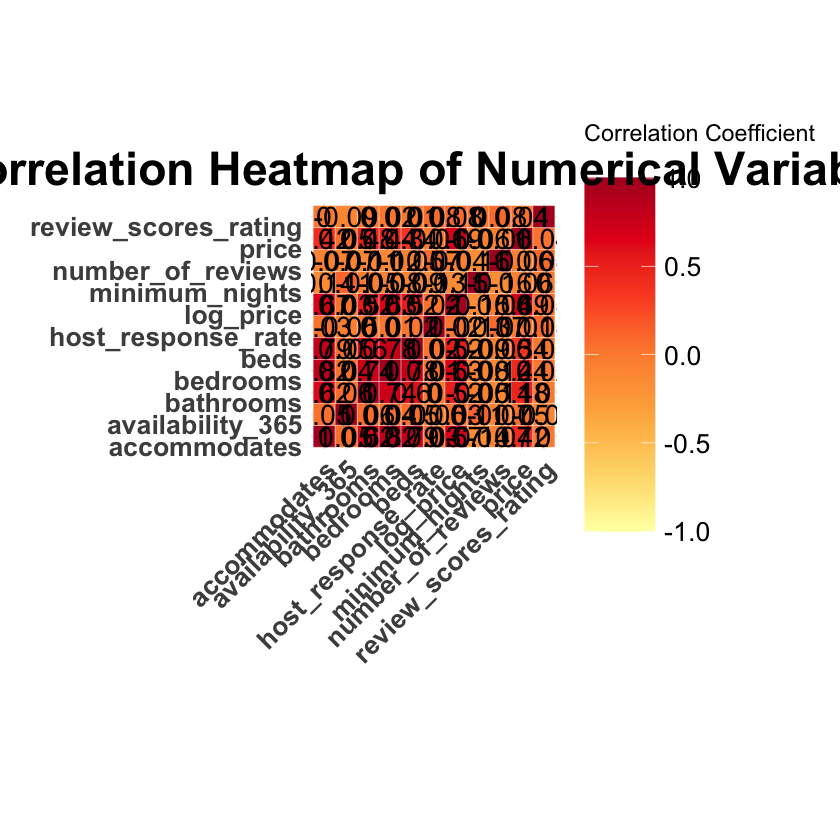

In [89]:
cor_matrix2 <- data %>%
    select_if(is.numeric) %>%
   cor() %>%
   as_tibble(rownames = 'var1') %>%
   pivot_longer(-var1, names_to = "var2", values_to = "corr")

cor_heatmap2 <- cor_matrix2 %>%
    ggplot(aes(var1, var2)) + 
    geom_tile(aes(fill = corr), color = "white") + 
    scale_fill_distiller("Correlation Coefficient \n",
      palette =  "YlOrRd",
      direction = 1, 
      limits = c(-1,1)
    ) +
    labs(x = "", y = "", title = "Correlation Heatmap of Numerical Variables") +
    theme_minimal() +
    theme(
        plot.title = element_text(size = 28,face = "bold", hjust = 0.5),
        axis.text.x = element_text(angle = 45, vjust = 1, size = 16, hjust = 1, face = "bold"),
        axis.text.y = element_text(vjust = 1, size = 16, hjust = 1, face = "bold"),
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 16),
        legend.key.size = unit(1.5, "cm",)
    ) +
    coord_fixed() +
    geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6)
cor_heatmap2

In [90]:
ggsave("correlation_heatmap_log.png", plot = cor_heatmap2, width = 20, height = 20, units = "in", dpi = 600)